In [8]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point,MultiPoint,Polygon
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

sns.set(font_scale=1.3)
sns.set_style("white")

# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.utils as su
import sklearn.metrics as sm
#from matplotlib import pyplot

In [2]:
import sklearn
print(sklearn.__version__)

0.24.2


In [3]:
data_Wildfire_eachfire_all = pd.read_csv("wildfire_all_properties_data_withgeometry_dropNdvi_20210617.csv")
data_Wildfire_eachfire_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14334 entries, 0 to 14333
Data columns (total 58 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fire_ID              14334 non-null  int64  
 1   Date                 14334 non-null  int64  
 2   AreaHa               14334 non-null  float64
 3   PerimeterM           14334 non-null  float64
 4   air_mean             14334 non-null  float64
 5   air_min              14334 non-null  float64
 6   air_max              14334 non-null  float64
 7   pre_mean             14334 non-null  float64
 8   pre_min              14334 non-null  float64
 9   pre_max              14334 non-null  float64
 10  soilw_mean           14334 non-null  float64
 11  soilw_min            14334 non-null  float64
 12  soilw_max            14334 non-null  float64
 13  air_mean_spring      14334 non-null  float64
 14  air_mean_summer      14334 non-null  float64
 15  air_mean_autumn      14334 non-null 

In [4]:
# data filter
data_Wildfire_eachfire_all_2 = data_Wildfire_eachfire_all.copy()
print(data_Wildfire_eachfire_all_2.shape)
data_Wildfire_eachfire_all_2 = data_Wildfire_eachfire_all_2.drop(index=data_Wildfire_eachfire_all_2.AreaHa[data_Wildfire_eachfire_all_2.AreaHa>10000].index)# >10000
print(data_Wildfire_eachfire_all_2.shape)
data_Wildfire_eachfire_all_2 = data_Wildfire_eachfire_all_2.drop(index=data_Wildfire_eachfire_all_2.AreaHa[data_Wildfire_eachfire_all_2.AreaHa<0.1].index)# <1000
print(data_Wildfire_eachfire_all_2.shape)

(14334, 58)
(14174, 58)
(13088, 58)


In [5]:
data_Wildfire_eachfire_y = pd.DataFrame(data_Wildfire_eachfire_all_2,columns=["AreaHa"])
data_Wildfire_eachfire_X = data_Wildfire_eachfire_all_2.copy()
data_Wildfire_eachfire_X = pd.DataFrame(data_Wildfire_eachfire_all_2,columns=["air_mean","pre_mean", \
                                                                            "soilw_mean","wind_mean (m.s++-1)","Slope_mean","grid_code_mean","Classify"])
data_Wildfire_eachfire_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13088 entries, 0 to 14333
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   air_mean             13088 non-null  float64
 1   pre_mean             13088 non-null  float64
 2   soilw_mean           13088 non-null  float64
 3   wind_mean (m.s++-1)  13088 non-null  float64
 4   Slope_mean           13088 non-null  float64
 5   grid_code_mean       13088 non-null  float64
 6   Classify             13088 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 818.0 KB


In [15]:
# calculate VIF for each variance
def checkVIF_new(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    #df["Const"] = 1
    name = df.columns
    x = np.matrix(df)
    VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
    VIF = pd.DataFrame({'feature':name,"VIF":VIF_list})
    VIF = VIF.drop(index=(VIF["feature"].loc[(VIF["feature"] == "c")].index))
    max_VIF = VIF["VIF"].max()
    print(max_VIF)
    return VIF
X_rep = data_Wildfire_eachfire_X.copy()
X_rep["c"] = 1 # 常数项
X_rep.head()
VIF = checkVIF_new(X_rep)
# save VIF data
VIF_2 = VIF.copy()
VIF_2.loc[3:3,("feature")]=["wind_mean (m/s)"]
VIF_2.loc[5:5,("feature")]=["NDVI_mean"]
VIF_2.loc[6:6,("feature")]=["Vegetation"]
VIF_2.to_csv("./VIF_wildfire_area.csv",header=True,index=False)
VIF_2

3.8604585933830395


,feature,VIF
0,air_mean,1.313646
1,pre_mean,3.689676
2,soilw_mean,3.860459
3,wind_mean (m/s),1.331712
4,Slope_mean,1.615526
5,NDVI_mean,1.678392
6,Vegetation,1.039132


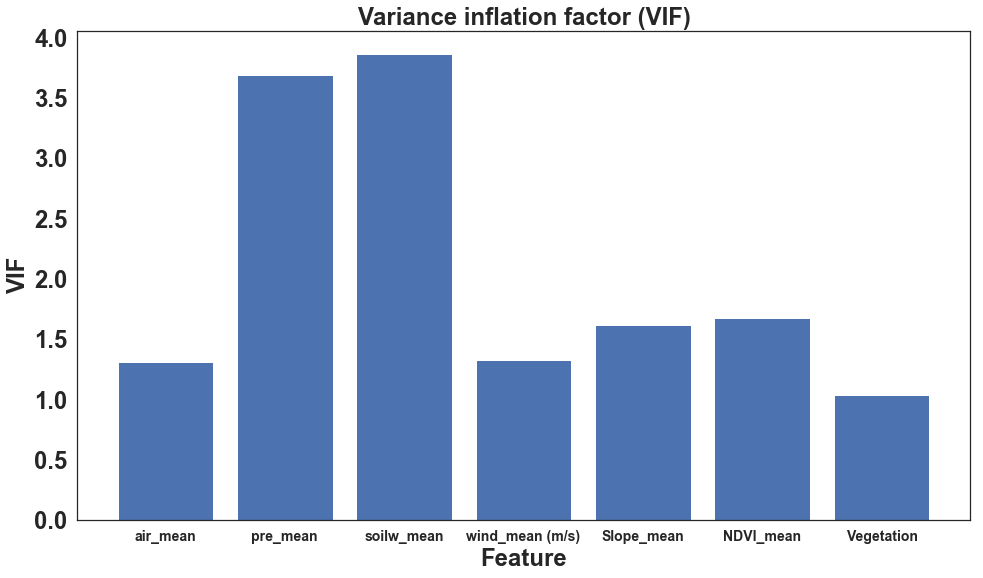

In [9]:
# Plot figure about VIF
plt.figure(figsize=(16,9))
plt.bar(VIF_2["feature"],VIF_2["VIF"])
plt.xlabel("Feature",fontsize=24,fontweight="bold")
plt.ylabel("VIF",fontsize=24,fontweight="bold")
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=24,fontweight='bold')
plt.title("Variance inflation factor (VIF)",fontsize=24,fontweight="bold")
#plt.savefig("VIF_wildfire_area.tiff")

In [10]:
# get the virance after VIF judgements
data_Wildfire_eachfire_y_2 = pd.DataFrame(data_Wildfire_eachfire_all_2,columns=["AreaHa"])
data_Wildfire_eachfire_X_2 = pd.DataFrame(data_Wildfire_eachfire_all_2,columns=["air_mean","pre_mean","soilw_mean","wind_mean (m.s++-1)","Slope_mean","grid_code_mean","Classify"])
data_Wildfire_eachfire_X_2 = data_Wildfire_eachfire_X_2.rename(columns={"wind_mean (m.s++-1)":"wind_mean (m/s)","grid_code_mean":"NDVI_mean","Classify":"Vegetation"})
data_Wildfire_eachfire_X_2.info()
data_Wildfire_eachfire_X_2.columns[0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13088 entries, 0 to 14333
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   air_mean         13088 non-null  float64
 1   pre_mean         13088 non-null  float64
 2   soilw_mean       13088 non-null  float64
 3   wind_mean (m/s)  13088 non-null  float64
 4   Slope_mean       13088 non-null  float64
 5   NDVI_mean        13088 non-null  float64
 6   Vegetation       13088 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 818.0 KB


'air_mean'

In [12]:
# define the model
model = RandomForestRegressor(max_depth=10,n_estimators=400,random_state=1,min_samples_split=5,max_leaf_nodes=60,min_weight_fraction_leaf=0.02,bootstrap=True,oob_score=True)
# fit the model
model.fit(data_Wildfire_eachfire_X_2, data_Wildfire_eachfire_y_2)
# regression score
score = model.score(data_Wildfire_eachfire_X_2, data_Wildfire_eachfire_y_2)
print("RandomForest---score: %.5f" % (score))
oob_score = model.oob_score_
print("RandomForest---oob_score: %.5f" % (oob_score))
# get importance
importance = model.feature_importances_
# get columns name
list_name = list(data_Wildfire_eachfire_X_2)
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, \t Score: %.5f' % (list_name[i],v))


D:\ProgramFile\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForest---score: 0.05199
RandomForest---oob_score: 0.02937
Feature: air_mean, 	 Score: 0.22512
Feature: pre_mean, 	 Score: 0.10576
Feature: soilw_mean, 	 Score: 0.14187
Feature: wind_mean (m/s), 	 Score: 0.31453
Feature: Slope_mean, 	 Score: 0.11092
Feature: NDVI_mean, 	 Score: 0.07254
Feature: Vegetation, 	 Score: 0.02925


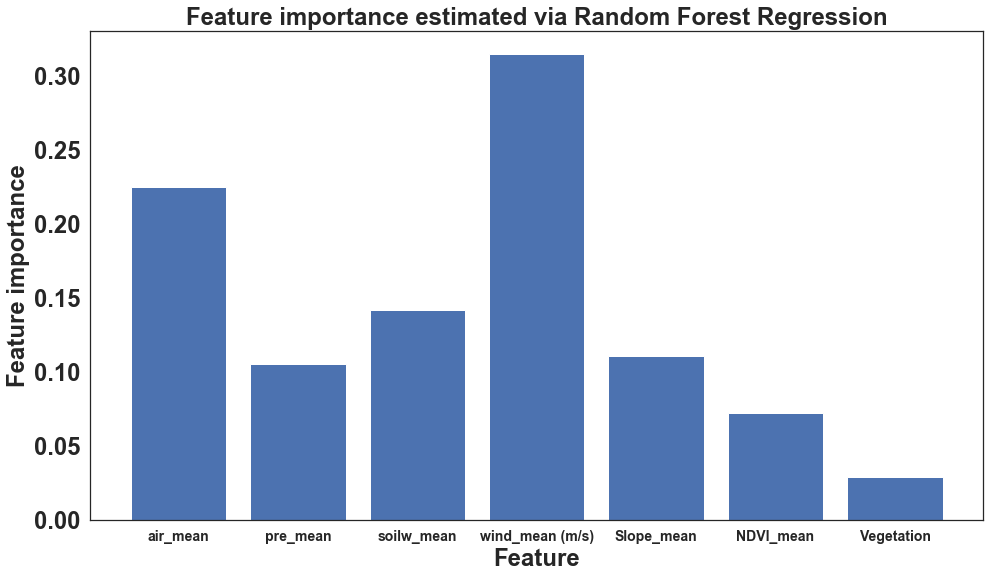

In [14]:
# 绘制importance条形图
plt.figure(figsize=(16,9))
plt.bar(list_name,importance)
plt.xlabel("Feature",fontsize=24,fontweight="bold")
plt.ylabel("Feature importance",fontsize=24,fontweight="bold")
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=24,fontweight='bold')
plt.title("Feature importance estimated via Random Forest Regression",fontsize=24,fontweight="bold")
#plt.savefig("FeatureImportance_wildfire_area.tiff")
plt.show()

In [16]:
df_FeatureImportance = pd.DataFrame({"Feature":np.array(list_name), 
                                       "Feature importance":np.array(importance)})
df_FeatureImportance.to_csv("./FeatureImportance_wildfire_area.csv",header=True,index=False)
df_FeatureImportance

,Feature,Feature importance
0,air_mean,0.225125
1,pre_mean,0.105764
2,soilw_mean,0.141865
3,wind_mean (m/s),0.314531
4,Slope_mean,0.110918
5,NDVI_mean,0.072544
6,Vegetation,0.029253
